In [ ]:
# Run this cell to upload your kaggle.json file
from google.colab import files
import os

# Prompt to upload the file
uploaded = files.upload()

# Set up the Kaggle directory and permissions
if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API token configured successfully!")
else:
    print("kaggle.json not found. Please upload the file.")

In [6]:
!pip install kagglehub datasets -q

In [7]:
!pip install wandb -q

In [ ]:
import wandb
wandb.login()

In [11]:
import kagglehub
import os
from datasets import load_dataset

print("Downloading dataset from Kaggle...")
# This downloads the files and returns the root path where they are stored
dataset_path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")
print(f"Dataset downloaded to: {dataset_path}")

# 3. Construct the full path to the image folder
# The images are inside the 'PetImages' subdirectory
image_folder_path = os.path.join(dataset_path, "PetImages")

# 4. Load the dataset using the "imagefolder" builder from Hugging Face
# This tells the library to treat the directory as an image dataset
print("Loading images into Hugging Face Dataset...")
hf_dataset = load_dataset("imagefolder", data_dir=image_folder_path)

print("\n✅ Successfully loaded as a Hugging Face Dataset:")
print(hf_dataset)

Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
Dataset downloaded to: /kaggle/input/microsoft-catsvsdogs-dataset
Loading images into Hugging Face Dataset...


Resolving data files:   0%|          | 0/25002 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]


✅ Successfully loaded as a Hugging Face Dataset:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 25000
    })
})


In [12]:
import shutil
import os

original_data_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
copied_data_dir = '/kaggle/working/PetImages_copy'

# Remove the copied directory if it already exists to start fresh
if os.path.exists(copied_data_dir):
    shutil.rmtree(copied_data_dir)

print("Copying dataset to a writable directory...")
shutil.copytree(original_data_dir, copied_data_dir)
print("Copying complete.")

Copying dataset to a writable directory...
Copying complete.


In [13]:
import os
from PIL import Image

# Define the path to your main PetImages directory
data_dir = '/kaggle/working/PetImages_copy'
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Get the class names (Cat, Dog)
class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Loop through each class directory
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Loop through each image in the class directory
    for fname in os.listdir(class_dir):
        # Check for valid image extensions
        if fname.lower().endswith(tuple(image_extensions)):
            image_path = os.path.join(class_dir, fname)
            try:
                # Try to open the image
                with Image.open(image_path) as img:
                    img.verify() # Verify the image integrity
            except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                print(f'Corrupted image found and deleted: {image_path}')
                os.remove(image_path) # Delete the corrupted file

print("Dataset cleaning complete.")

Corrupted image found and deleted: /kaggle/working/PetImages_copy/Cat/666.jpg
Corrupted image found and deleted: /kaggle/working/PetImages_copy/Dog/11702.jpg


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dataset cleaning complete.


In [14]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader, random_split

cudnn.benchmark = True
plt.ion()   # interactive mode

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
base_data_dir = '/kaggle/working/PetImages_copy'
train_dataset_full = datasets.ImageFolder(base_data_dir, transform=data_transforms['train'])
val_dataset_full   = datasets.ImageFolder(base_data_dir, transform=data_transforms['val'])

train_size = int(0.8 * len(train_dataset_full))
val_size   = len(train_dataset_full) - train_size


indices = torch.randperm(len(train_dataset_full))
train_idx = indices[:train_size]
val_idx   = indices[train_size:]
train_dataset = torch.utils.data.Subset(train_dataset_full, train_idx)
val_dataset   = torch.utils.data.Subset(val_dataset_full, val_idx)

# --- 5. Apply the VAL Transforms to the Validation Subset ---
# Since random_split creates a Subset object, we can override its transform.
# This ensures validation data is not augmented with RandomResizedCrop/Flip.
val_dataset.dataset.transform = data_transforms['val']


# --- 6. Create the Dataloaders ---
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4) # typically no shuffle for val
}

# --- 7. Update Dataset Sizes and Class Names ---
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset_full.classes

print("Class Names:", class_names)
print("Training Size:", dataset_sizes['train'])
print("Validation Size:", dataset_sizes['val'])
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Class Names: ['Cat', 'Dog']
Training Size: 19998
Validation Size: 5000
Using cpu device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


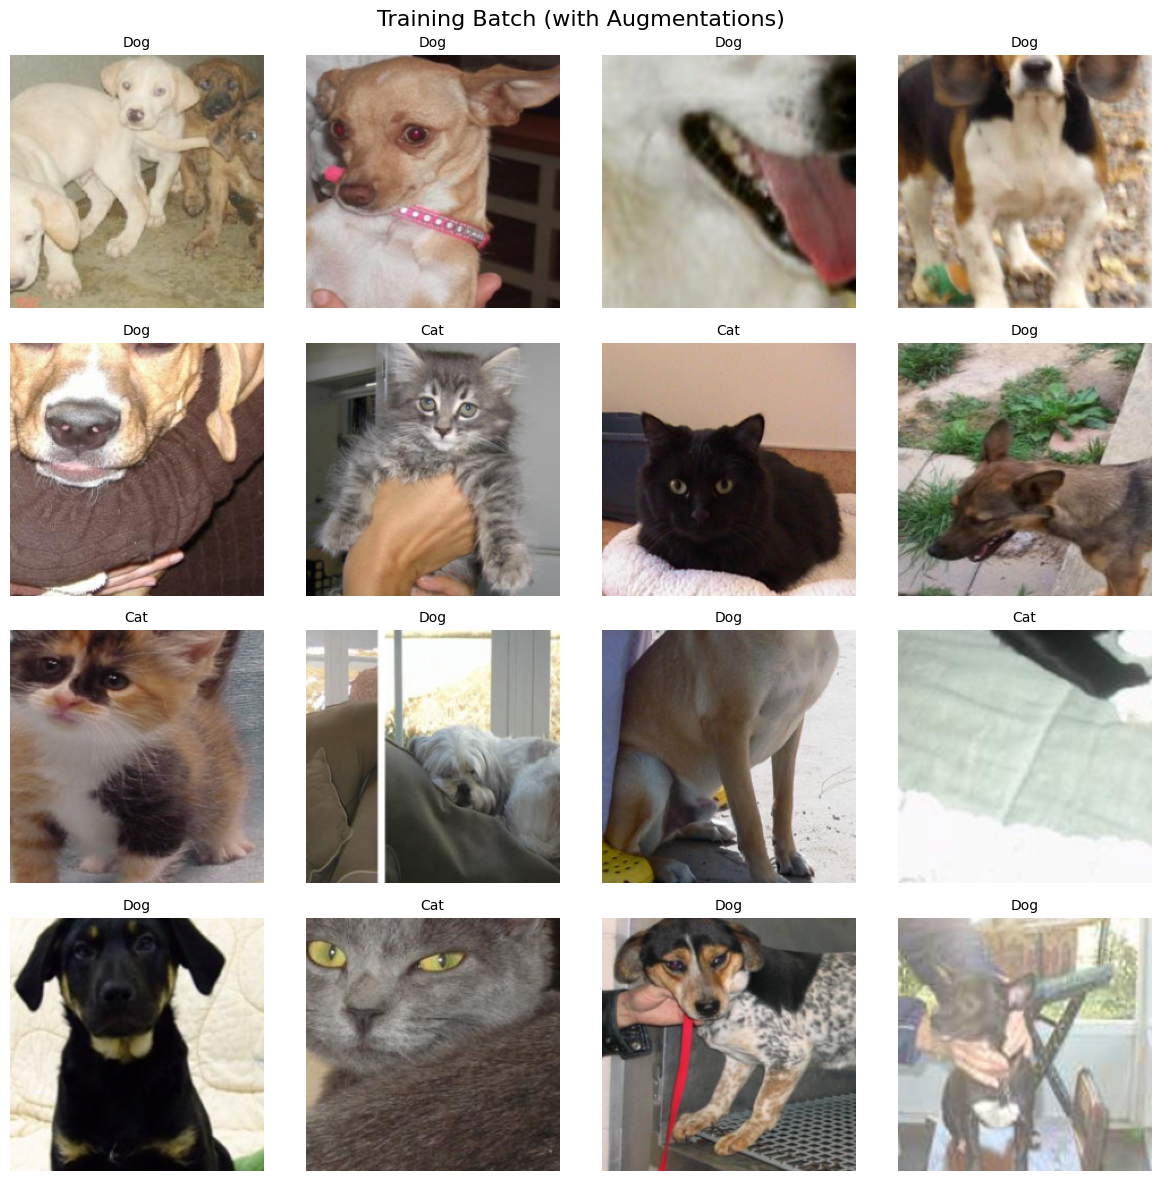

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

def show_batch(dataloader, class_names, n_images=16, title="Sample Training Images"):
    """Display a batch of images with their labels in a clean grid."""
    # Get one batch
    inputs, classes = next(iter(dataloader))

    # Make sure we don’t go over the number of images in the batch
    n_images = min(n_images, inputs.size(0))

    # Create a figure
    cols = 4
    rows = n_images // cols + int(n_images % cols != 0)
    plt.figure(figsize=(cols * 3, rows * 3))
    plt.suptitle(title, fontsize=16)

    # Unnormalize function
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(n_images):
        ax = plt.subplot(rows, cols, i + 1)
        img = inputs[i].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(class_names[classes[i]], fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
show_batch(dataloaders['train'], class_names, n_images=16, title="Training Batch (with Augmentations)")


In [17]:
import wandb # Make sure wandb is imported
import time
from tempfile import TemporaryDirectory
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # --- TELL W&B TO WATCH THE MODEL ---
        # This will log gradients and parameters (optional but useful)
        wandb.watch(model, log="all", log_freq=10)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # --- NEW: LOG METRICS TO W&B ---
                if phase == 'train':
                    wandb.log({"train_acc": epoch_acc, "train_loss": epoch_loss, "epoch": epoch})
                else:
                    wandb.log({"val_acc": epoch_acc, "val_loss": epoch_loss, "epoch": epoch})

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    # --- NEW: FINISH THE W&B RUN ---
    wandb.finish()

    return model

In [18]:
def visualize_model(model, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle("Model Predictions", fontsize=16)

    # Unnormalize function
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad(): # Turn off gradients for prediction
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                # Format the title to show prediction and true label
                ax.set_title(f'Predicted: {class_names[preds[j]]} | True: {class_names[labels[j]]}')

                # Display the image
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training) # Set model back to original mode
                    plt.tight_layout()
                    plt.show()
                    return
    model.train(mode=was_training)

In [20]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
wandb.init(
    project="cats-vs-dogs-resnet",
    config={
        "learning_rate": 0.001,
        "architecture": "ResNet18",
        "optimizer": "SGD",
        "momentum": 0.9,
        "lr_scheduler": "StepLR",
        "scheduler_step_size": 7,
        "scheduler_gamma": 0.1,
        "loss_function": "CrossEntropyLoss",
        "epochs": 25,
    }
)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft, dataloaders['val'], class_names)